In [1]:
%load_ext autoreload
%autoreload 2

import lzma
import dill
import json
import pandas as pd
import shap
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from pathlib import Path

import scienceplots

import matplotlib.pyplot as plt
import matplotlib as mpl

from matal import load_model, load_data, auto_log, DATA_DIR, MODEL_DIR, cache_return

In [2]:
plt.style.use(['science', 'no-latex', 'ieee'])

params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'font.family': "Arial",
   'legend.fontsize': 9,
   'xtick.labelsize': 9,
   'ytick.labelsize': 9,
   'figure.figsize': (4.0, 2.8),
   'figure.dpi': 72,
}

mpl.rcParams.update(params)

### Reverse Design

In [3]:
vmodel = load_model('vmodels_final')
vmodel

{'VLTransmittance': MOVotingRegressor(estimators=[('14_VLTransmittance_1_VJ3HSBM3',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_1_VJ3HSBM3',
                                           output_scale=100)),
                               ('14_VLTransmittance_2_PCSTZBJN',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_2_PCSTZBJN',
                                           output_scale=100)),
                               ('14_VLTransmittance_3_VUUFLQTS',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_3_VUUFLQTS',
                                           output_scale=100)),
                               ('14_VLTransmittance_4_VJ3HSBM3',
                                MLPNetwork(input_norm=True,
                                           name='

In [4]:
xyz = load_model('perf.n151_c85_xyz').feasible_xyz_4d
X_COLS = ['MMT', 'CNF', 'GEL', 'GLY']

pred_df = pd.DataFrame(xyz, columns=X_COLS)
for y, m in tqdm(vmodel.items()):
    pred_df[y] = m.predict(pred_df[X_COLS])
pred_df

  0%|          | 0/9 [00:00<?, ?it/s]

,MMT,CNF,GEL,GLY,VLTransmittance,UVTransmittance,IRTransmittance,AshAreaRatio,Stress,Strain,Modulus,CurveAlpha,CurveBeta
0,0.000000,0.266667,0.726667,0.006667,80.135292,70.161606,83.008972,0.394240,27.115520,0.001669,3288.117188,0.371258,3.369310e-11
1,0.000000,0.266667,0.720000,0.013333,80.529037,69.891296,84.295410,0.383913,33.100330,0.001791,3285.237061,0.351295,2.125942e-11
2,0.000000,0.266667,0.713333,0.020000,80.935608,69.586716,85.244637,0.371030,37.296543,0.002002,3264.256836,0.324893,1.482311e-11
3,0.000000,0.266667,0.706667,0.026667,81.336349,69.248131,86.117386,0.354087,40.020332,0.002430,3233.968994,0.311310,8.643141e-12
4,0.000000,0.266667,0.700000,0.033333,81.701248,68.878922,87.027084,0.348031,41.427418,0.002987,3213.198486,0.308863,4.279595e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208682,0.833333,0.000000,0.146667,0.020000,23.369196,5.114288,62.167168,0.941223,42.691910,0.015942,5013.510742,0.376609,2.225935e-10
208683,0.833333,0.006667,0.160000,0.000000,23.133327,4.870012,60.884987,0.916061,48.157181,0.013642,5226.773438,0.377074,4.731639e-10
208684,0.833333,0.006667,0.153333,0.006667,23.261990,4.969387,61.568859,0.928541,47.789085,0.014477,5088.430176,0.377462,4.278415e-10
208685,0.840000,0.000000,0.160000,0.000000,22.303209,4.893387,60.388935,0.918378,45.562706,0.014020,5238.026855,0.375225,3.766648e-10


In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

app_sihs_df = pred_df.copy()
app_sihs_df['Score'] = np.clip(app_sihs_df.Stress - 90, None, 0) / 100.0 + \
                       np.clip(app_sihs_df.Modulus - 7400, None, 0) / 100.0

app_sihs_df = app_sihs_df.sort_values(by='Score', ascending=False, ignore_index=True)
app_sihs_df = app_sihs_df[app_sihs_df.Score >= 0]
app_sihs_df

X = app_sihs_df[X_COLS]
plot_X = X[['MMT', 'CNF', 'GLY']]

db = DBSCAN(eps=0.15, min_samples=20).fit(plot_X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_ = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
n_noise_ = list(labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))\


Estimated number of clusters: 2
Estimated number of noise points: 5


In [8]:
from matal.vis import generate_fesb_trisurf, skimg_tri_to_poly, smooth_pvs_poly, poly_to_skimg_tri, remove_legend_alpha

fesb_est = load_model('svm')
verts_org, faces_org = generate_fesb_trisurf(fesb_est, cutoff=0.85, n_points=221)
poly_org = skimg_tri_to_poly(verts_org, faces_org)
poly = smooth_pvs_poly(poly_org)
verts, faces = poly_to_skimg_tri(poly)

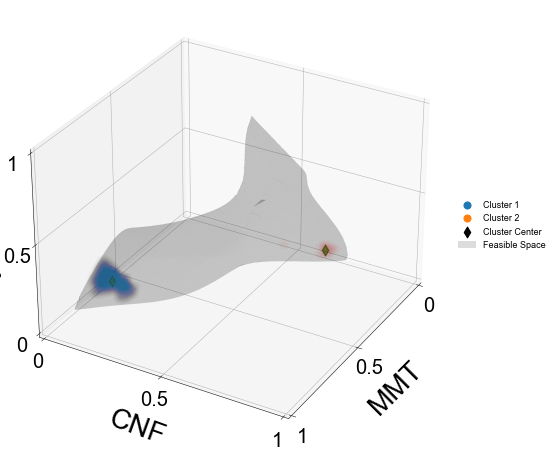

In [9]:
import matplotlib as mpl
import os

mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Arial'

def style_db_ax(ax, pad_scale=-1.0):
    ax.zaxis.set_rotate_label(False)
    [getattr(ax, f'set_{a}label')(l, labelpad=p * pad_scale * 3, rotation=r, fontsize=LABEL_SIZE) for a, l, r, p in zip('xyz', 
                                                                                   ['MMT', 'CNF', 'Glycerol'], 
                                                                                   [45, -20, 90],
                                                                                   [-5, -5, -2])]
    [getattr(ax, f'set_{a}lim')(0, 1) for a in 'xyz']
    [getattr(ax, f'set_{a}ticks')([], minor=True) for a in 'xyz']
    [getattr(ax, f'set_{a}ticks')([0, 0.5, 1]) for a in 'xyz']
    [getattr(ax, f'set_{a}ticklabels')(['0', '0.5', '1'], fontsize=TICK_SIZE) for a in 'xyz']


    ax.tick_params(axis='x', pad=-2 * pad_scale, rotation=0)
    ax.tick_params(axis='y', pad=-2 * pad_scale, rotation=0)
    ax.tick_params(axis='z', pad=-2 * pad_scale, rotation=0)
    ax.grid(False, which='major')
    ax.view_init(30, 30)


TICK_SIZE = 20
LABEL_SIZE = 28

fig_size = 8
fig = plt.figure(figsize=(1 * fig_size, 1 * fig_size))

ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], color=(0.3, 0.3, 0.3, 0.15), label='Feasible Space')
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d

for l, c in zip(range(n_clusters_), ['tab:blue', 'tab:orange']):
    ax.scatter(*plot_X[labels_ == l].values.T, c=c, alpha=0.005, label=f'Cluster {l + 1}', s=50)
for l, c in zip(range(n_clusters_), ['tab:blue', 'tab:orange']):
    ax.scatter(*plot_X[labels_ == l].values.mean(axis=0), marker='d', edgecolor='k', s=60, c='k', alpha=0.5, zorder=999, label=f'Cluster Center' if l == (n_clusters_ - 1) else None)

    
[getattr(ax, f'set_{a}label')(t) for a, t in zip('xyz', X_COLS[:3])]
[getattr(ax, f'set_{a}lim')(0, 1) for a in 'xyz']
ax.view_init(30, 45)

style_db_ax(ax)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
remove_legend_alpha(ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1., 0.5)))

# fig.savefig('cluster.png', transparent=True, dpi=600, bbox_inches='tight')